<a href="https://colab.research.google.com/github/Seonghoon-Yu/ISLR-Python/blob/main/Chapter_5_Resampling_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5 Resampling Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

# 데이터셋 불러오기

In [3]:
!git clone https://github.com/emredjan/ISL-python

fatal: destination path 'ISL-python' already exists and is not an empty directory.


In [4]:
# Auto.csv 불러오기
df1 = pd.read_csv('/content/ISL-python/datasets/Auto.csv', na_values='?').dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


# 5.1 Cross-Validation
### Valiadation Set Approach
- 전체 dataset을 2 분할하여 train, validation set을 생성합니다.
- 영향력이 높은 관측치가 train, validation 중 어디에 속하느냐에 따라 MSE가 달라집니다.
- 전체 관측치의 일부만 train에 사용됩니다.

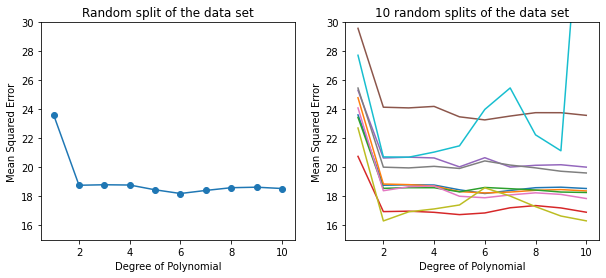

In [8]:
t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size, r_state.size))

regr = skl_lm.LinearRegression()

# dataset 무작위로 10번 분할하기
for (i,j), v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
    
    regr.fit(X_train, y_train) # 선형 회귀 fit
    pred = regr.predict(X_test) # 예측값
    Z[i,j] = mean_squared_error(y_test, pred) # mse 기록

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

# 왼쪽 plot
ax1.plot(X.T[0],Z.T[0],'-o')
ax1.set_title('Random split of the data set')

# 오른쪽 plot
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2,11,2))

### Leave One Out Cross-validation과 k-fold 비교

#### LOOCV(Leave One Out Cross-Validation)
- 단 하나의 관측값(x1,y1)만 validation set으로 사용합니다.
- 나머지 관측값 n-1개는 train set으로 사용합니다.
- n번 fitting 하여 출력한 MSE를 평균합니다.
- 전체 데이터셋 크기만큼 fitting을 진행하므로 랜덤성이 없습니다.
- n-1개의 관측값을 사용하므로 bias가 낮습니다.
- overfitting 되어 variance가 높습니다.
- n번 fitting 하므로 expensive 합니다.

#### k-fold
- 전체 데이터 셋을 k개로 분할하여 n/k 개를 validation set, n-n/k개를 train set으로 사용합니다.
- k번 fitting을 진행하여 출력한 k개의 MSE를 평균합니다.
- 연산량에 이점이 있습니다.
- 중간 정도의 bias, variance를 갖습니다.

In [9]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df1)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df1.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

In [11]:
# k-fold CV
folds = 10
elements = len(df1.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds)
    Z[i,j] = cross_val_score(regr, X_poly, df1.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()    

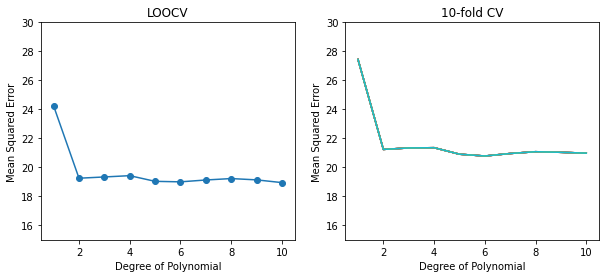

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))


# 왼쪽 plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# 오른쪽 plot
ax2.plot(X,Z*-1)
ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));